# Explore AIMed Dataset


### AIMed dataset preprocessing

 - Download from ftp://ftp.cs.utexas.edu/pub/mooney/bio-data/interactions.tar.gz"

 - Convert the raw dataset into XML for using instructions in http://mars.cs.utu.fi/PPICorpora/ 
 
 ```python
 convert_aimed.py -i  aimed_interactions_input_dir -o aimed.xml
 ```

Acknowledgements:
 Pyysalo S, Airola A, Heimonen J, Björne J, Ginter F, Salakoski T, Comparative Analysis of Five Protein-protein Interaction Corpora, LBM'07. 2007.


In [1]:
xmlfile = "aimed.xml"

In [2]:
import sys
sys.path.append('./source')

#### Covert to pandas

In [3]:
from datatransformer.AimedXmlToDataFrame import AimedXmlToDataFrame
df = AimedXmlToDataFrame()(xmlfile)


In [4]:
df.query("docid=='AIMed.d35'")

,docid,isValid,participant1,participant1_loc,participant2,participant2_loc,passage,passageid
696,AIMed.d35,False,presenilin 1,83-94,PS1,97-99,Most familial early-onset Alzheimer's disease ...,AIMed.d35.s292
697,AIMed.d35,False,PS1,156-158,PS1,63-65,Although numerous studies revealed predominant...,AIMed.d35.s294
698,AIMed.d35,True,PS1,13-15,ABP-280,78-84,Cell surface PS1 formed complexes in vivo with...,AIMed.d35.s299
699,AIMed.d35,False,filamin,69-75,ABP-280,78-84,Cell surface PS1 formed complexes in vivo with...,AIMed.d35.s299
700,AIMed.d35,True,PS1,13-15,filamin,69-75,Cell surface PS1 formed complexes in vivo with...,AIMed.d35.s299


In [5]:
df[df['passage'].str.contains("inactive IL-1beta precursor")]["passage"].iloc[ 1]

'The interleukin-1beta (IL-1beta) converting enzyme (ICE) processes the inactive IL-1beta precursor to the proinflammatory cytokine.'

In [6]:
df[df['passage'].str.contains("inactive IL-1beta precursor")]

,docid,isValid,participant1,participant1_loc,participant2,participant2_loc,passage,passageid
4971,AIMed.d192,False,interleukin-1beta,4-20,interleukin-1beta (IL-1beta) converting enzyme,4-49,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4972,AIMed.d192,False,IL-1beta,23-30,interleukin-1beta,4-20,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4973,AIMed.d192,False,interleukin-1beta,4-20,IL-1beta,80-87,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4974,AIMed.d192,True,interleukin-1beta,4-20,ICE,52-54,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4975,AIMed.d192,False,IL-1beta,23-30,interleukin-1beta (IL-1beta) converting enzyme,4-49,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4976,AIMed.d192,False,interleukin-1beta (IL-1beta) converting enzyme,4-49,IL-1beta,80-87,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4977,AIMed.d192,False,interleukin-1beta (IL-1beta) converting enzyme,4-49,ICE,52-54,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4978,AIMed.d192,False,IL-1beta,23-30,IL-1beta,80-87,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4979,AIMed.d192,True,IL-1beta,23-30,ICE,52-54,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636
4980,AIMed.d192,False,ICE,52-54,IL-1beta,80-87,The interleukin-1beta (IL-1beta) converting en...,AIMed.d192.s1636


In [7]:
df.shape

(5834, 8)

In [8]:
unique_passages = df["passage"].unique()
unique_sentence_count=[ len(r.split("\n")) for r in unique_passages]
print("Unique setences :  " , sum(unique_sentence_count))

Unique setences :   1169


### Explore dataset

In [9]:
import matplotlib.pyplot as plt

df["isValid"].value_counts().plot.pie(autopct='%.2f',figsize=(4, 4))
plt.show()

<Figure size 400x400 with 1 Axes>

In [10]:
df["isValid"].value_counts()

False    4834
True     1000
Name: isValid, dtype: int64

In [11]:
df.to_json("AIMedFull.json")

## Split into train/test/validation

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_docids = df.docid.unique()
stratified =  [ df.query("docid == '{}'".format(p))['isValid'].iloc[0] for p in unique_docids]
traindocid, valdocid = train_test_split(unique_docids,  test_size=.1,
                                                        random_state=777, stratify=stratified)

In [10]:
train = df[df['docid'].isin(traindocid)]
val = df[df['docid'].isin(valdocid)]




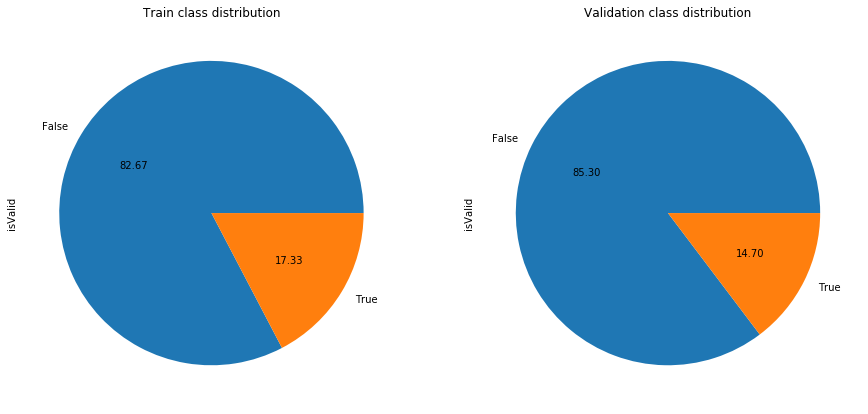

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])



plt.show()

In [12]:
train.to_json("AIMedtrain.json")
val.to_json("AIMedval.json")

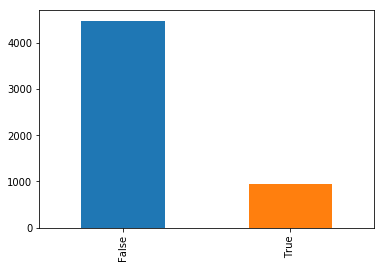

In [13]:
train.isValid.value_counts().plot.bar()

In [17]:
word_count= train.apply(lambda r: len(r["passage"].split(" ")), axis=1)

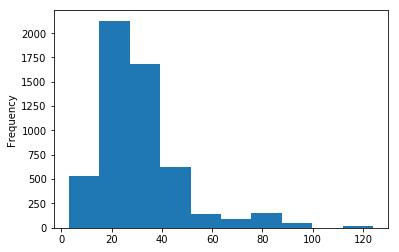

In [18]:
word_count.plot.hist()

In [16]:
train.sample(n=20).to_json("Aimedsample.json")

## Split into train/validation without looking at pubmed overlap

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


train_p, val_p = train_test_split(df,  test_size=.1,
                                                        random_state=777, stratify=df["isValid"])

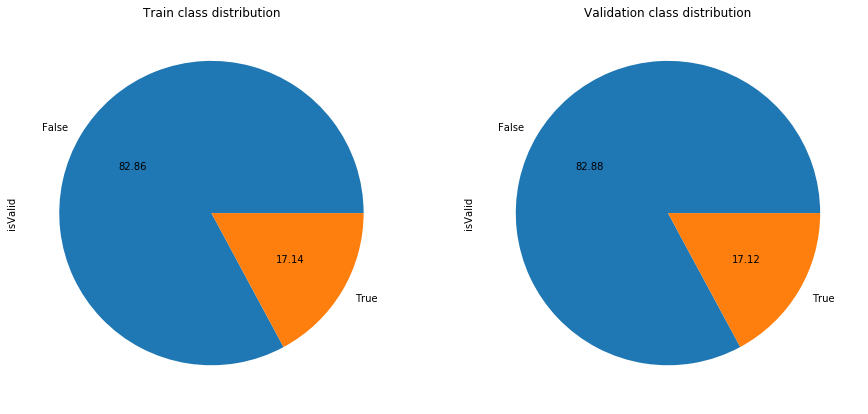

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(15,20))

ax[0].set_title('Train class distribution')
train_p.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val_p.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])



plt.show()

In [29]:
train_p.to_json("AIMedtrain_pubmedoverlap.json")
val_p.to_json("AIMedval_pubmedoverlap.json")

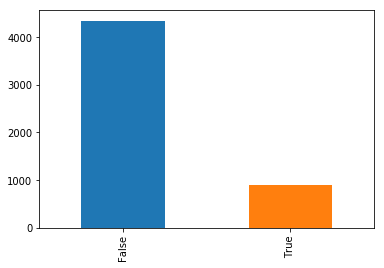

In [30]:
train_p.isValid.value_counts().plot.bar()